In [1]:
from utils_req import *

In [2]:
"""
Choose the dataset. We have two datasets: 1 and 9
"""
dataset = 9

In [3]:
"""
Compute receptive fields using STA of responses to Monet
1. Load the Monet stimulus movies
2. Load the responses corresponding to the highest contrast bin
3. Compute STA for all neurons if 
"""
# 1. Load the Monet stimulus movies
Data = loadmat('./Monet/MonetMovies.mat')
MonetMovies = Data['MonetMovies']
del Data

#activations from the first 3 frames of the movies are discarded
MonetMovies = MonetMovies[:,:,3:,:]

Ny, Nx, T = MonetMovies.shape[0:3]
N_Contrastlevels = 10 #no. of contrast levels 
NClips = 100 # no. of clips, each presented at different contrast levels
MonetMovies = MonetMovies.reshape(Ny,Nx,T,N_Contrastlevels,NClips)
MonetMovies = MonetMovies.transpose(3,4,2,0,1)



# 2. Load the responses to highest contrast bin
r_name = './EricNet_Tiled/MonetResponses/MonetMovies_responses_' + str(dataset) + '_9.npy'
responses = np.load(r_name)
NNeu = responses.shape[2]

# 3. Compute STA if it has not been computed yet
fname = './EricNet_Tiled/ReceptiveFields_' + str(dataset) + '.mat'
if Path(fname).exists():
    Data = loadmat(fname)
    ReceptiveFields = Data['ReceptiveFields']
    del Data
else:
    ReceptiveFields = np.zeros([NNeu,Ny,Nx])
    lag = 1
    # obtain the RFs using STA
    for nn in tqdm(range(NNeu)):
        ReceptiveFields[nn,:,:] = np.sum(np.sum(expandN_dims(responses[:,lag:,nn],2)*(MonetMovies[9,:,:T-lag,:,:] - 127.5),axis=0),axis=0)/(NClips*(T-lag))
        
    mdict = {'ReceptiveFields':ReceptiveFields}
    savemat(fname,mdict)
    
del responses, MonetMovies

In [4]:
# Compute the RF centers and quality of RFs
ReceptiveFields, RxVec, RyVec, RF_snr = ProcessReceptiveFields(ReceptiveFields)

In [5]:
"""
Estimate the local orientations and contrasts for Monet if they have not been computed already
"""

fname = './Monet/EstimatedContrast_Monet.mat'
if Path(fname).exists():
    Data = loadmat(fname)
    ChatFull = Data['ChatFull']
    fname = './Monet/EstimatedOrientation_Monet.mat'
    Data = loadmat(fname)
    OhatFull = Data['OhatFull']
    del Data
    
else:
    OhatFull = np.zeros(MonetMovies.shape)
    ChatFull = np.zeros(MonetMovies.shape)

    # paramters for estimating orientation and contrast
    ksize = 19
    sigma_o = 5
    sigma_c = 5
    rs = 1.0

    for clip in tqdm(range(NClips)):
        for nbin in range(N_Contrastlevels):
            for t in range(T):
                OhatFull[nbin,clip,t], ChatFull[nbin,clip,t] = Extract_Orientation_Contrast(np.double(MonetMovies[nbin,clip,t]),ksize, sigma_o, sigma_c, rs)
                
    # Quantize Chat and Ohat
    OhatFull = np.uint8(np.floor(256*OhatFull/np.pi))
    ChatFull = np.uint8(np.floor(256*ChatFull/np.max(ChatFull[-1])))

    # save the files
    mdict = {'OhatFull':OhatFull}
    fname = './Monet/EstimatedOrientation_Monet.mat'
    savemat(fname, mdict)

    mdict = {'ChatFull':ChatFull}
    fname = './Monet/EstimatedContrast_Monet.mat'
    savemat(fname, mdict)   

In [6]:
"""
Remove the first 3 bins from Orientation and Contrast data
"""
OhatFull = OhatFull[:,:,3:]
ChatFull = ChatFull[:,:,3:]

In [7]:
"""
Build 2D tuning curves, if not computed yet
"""

Nbins_o = 11 #no. of orientation bins
Nbins_c = 21 #no. of contrast bins

fname = './EricNet_Tiled/TuningData_' + str(dataset) + '.mat'
if Path(fname).exists():
    Data = loadmat(fname)
    TuningCurves_2D = Data['TuningCurves_2D']
    BinCounts = Data['BinCounts']
    del Data

else:
    
    # now to build 2D tuning curves using the Monet stimulus

    TuningCurves_2D = np.zeros([NNeu, Nbins_c, Nbins_o]) # No. of Monet stimulus clips x No. of neurons x No. of orientation bins

    BinCounts = np.zeros([NNeu, Nbins_c, Nbins_o])

    t_st = time.time()

    for clevel in tqdm(range(N_Contrastlevels)):

        # load the responses for Monet at this contrast level
        './EricNet_Tiled/MonetResponses/MonetMovies_responses_1_0.npy'
        r_name = './EricNet_Tiled/MonetResponses/MonetMovies_responses_' + str(dataset) + '_' + str(clevel) + '.npy'
        responses = np.load(r_name)

        # quantize the required orientation and contrast maps
        ChatReq = np.uint8(np.floor(ChatFull[clevel]*(Nbins_c/256.0))) 
        OhatReq = np.uint8(np.floor(OhatFull[clevel]*(Nbins_o/256.0))) 

        for nn in range(NNeu):

            R_nn = responses[:,:,nn].flatten() #responses of neuron nn

            # receptive field centers of neuron nn
            px = RxVec[nn]
            py = RyVec[nn]

            for ii in range(Nbins_c):

                idx_c = np.nonzero(ChatReq[:,:,py,px].flatten() == ii)[0] #find indices where contrast = ii

                for jj in range(Nbins_o):

                    idx_o = np.nonzero(OhatReq[:,:,py,px].flatten() == jj)[0] #find indices where orientation = jj
                    idx_oc = np.intersect1d(idx_c, idx_o)  # intersection of contrast and orientation bin

                    BinCounts[nn,ii,jj] = BinCounts[nn,ii,jj] + len(idx_oc)

                    TuningCurves_2D[nn,ii,jj] = TuningCurves_2D[nn,ii,jj] + np.sum(R_nn[idx_oc])
                    
      # save raw Tuning Curve data
    mdict = {'TuningCurves_2D':TuningCurves_2D, 'BinCounts': BinCounts}
    savemat(fname, mdict)  
    
    del responses
    
del OhatFull, ChatFull

In [8]:
"""
Compute fits to tuning curves
We assume tuning curves are of the form c_A*tanh(c_B*contrast + c_C)*exp(k1*cos(2(theta-mu1)) + k2*cos(4(theta-mu2)))
"""

# Pick only contrast bins 4 through 11
# And divide by bincounts. Previously TuningCurves_2D just had sum of all activities for any given (c,o) bin
TuningCurves_2D = TuningCurves_2D[:,4:12,:]/BinCounts[:,4:12,:]

# orientation and contrast bin values for fitting
ori_set = (2*np.arange(Nbins_o)+1)*np.pi/2/Nbins_o
cont_set = (2*np.arange(Nbins_c)+1)/Nbins_c/2
cont_set = cont_set[4:12]
ori_2D,cont_2D = np.meshgrid(ori_set,cont_set)
tuningFn_inputs = np.concatenate((np.expand_dims(cont_2D.flatten(),axis=0),np.expand_dims(ori_2D.flatten(),axis=0)),axis=0)

Nbins_c = len(cont_set)
Nbins_o = len(ori_set)



fname = './EricNet_Tiled/TuningFitInfo_' + str(dataset)+ '.mat'

if Path(fname).exists():
    Data = loadmat(fname)
    c_A = Data['c_A'].squeeze()
    c_B = Data['c_B'].squeeze()
    c_C = Data['c_C'].squeeze()
    k1 = Data['k1'].squeeze()
    mu1 = Data['mu1'].squeeze()
    k2 = Data['k2'].squeeze()
    mu2 = Data['mu2'].squeeze()
    TuningCurves_Max = Data['TuningCurves_Max'].squeeze()
    TuningCurves_Fit = Data['TuningCurves_Fit']
    FitError = Data['FitError'].squeeze()
    
else:

    # Parameters of the tuning function
    c_A = np.zeros([NNeu]) # contrast tuning amplitude
    c_B = np.zeros([NNeu]) # contrast tuning slope
    c_C = np.zeros([NNeu]) # contrast tuning offset
    k1  = np.zeros([NNeu]) # orientation tuning concentration parameter 1st order
    mu1 = np.zeros([NNeu]) # preferred orientation 1st order
    k2  = np.zeros([NNeu]) # orientation tuning concentration parameter 2nd order
    mu2 = np.zeros([NNeu]) # preferred orientation 2nd order

    # initial values and bounds for the parameters
    init_vals = [1, 1, 0, 1, np.pi/2, 0, 0]
    lb = [-3,-3,-3,0,0,0,0]
    ub = [3,3,3,5,np.pi,5,np.pi/2]


    FitError = np.zeros([NNeu])
    TuningCurves_Fit = np.zeros(TuningCurves_2D.shape)

    TuningCurves_Max = np.zeros([NNeu])

    for k in tqdm(range(NNeu)):
        TuningCurves_Max[k] = TuningCurves_2D[k].max()
        best_vals, covar = curve_fit(TuningFunction, tuningFn_inputs, TuningCurves_2D[k].reshape(-1)/TuningCurves_Max[k], p0=init_vals,bounds=(lb,ub),max_nfev=40000)
        c_A[k] = best_vals[0]
        c_B[k] = best_vals[1]
        c_C[k] = best_vals[2]
        k1[k]  = best_vals[3]
        mu1[k] = best_vals[4]
        k2[k]  = best_vals[5]
        mu2[k] = best_vals[6]

        Fit = TuningFunction(tuningFn_inputs,c_A[k],c_B[k],c_C[k],k1[k],mu1[k],k2[k],mu2[k])
        FitError[k] = MSE(Fit,TuningCurves_2D[k]/TuningCurves_Max[k])
        TuningCurves_Fit[k] = Fit.reshape(len(cont_set),len(ori_set))

    mdict = {'c_A': c_A, 'c_B': c_B, 'c_C': c_C, 'k1': k1, 'mu1': mu1, 'k2': k2, 'mu2': mu2, 'TuningCurves_Max':TuningCurves_Max, 'TuningCurves_Fit': TuningCurves_Fit, 'FitError': FitError}
    savemat(fname, mdict)  
    

Total no. of neurons = 11402
No. of neurons selected for constructing PPCs = 6590


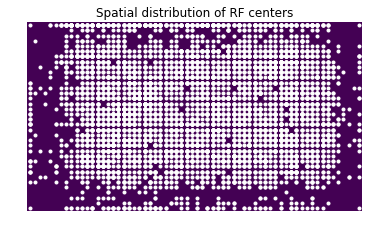

In [9]:
"""
Select the neurons with RF_snr > Th and plot the spatial distribution of the RF centers
"""

print('Total no. of neurons =', NNeu)

SNR_Threshold = 4.5
NIdx = np.nonzero(RF_snr > SNR_Threshold)[0]

# Retain information of only these neurons
ReceptiveFields = ReceptiveFields[NIdx]
RxVec = RxVec[NIdx]
RyVec = RyVec[NIdx]
RF_snr = RF_snr[NIdx]
NNeu = len(RF_snr)

# Retain information of tuning data
TuningCurves_2D = TuningCurves_2D[NIdx]
BinCounts = BinCounts[NIdx]
TuningCurves_Fit = TuningCurves_Fit[NIdx]
TuningCurves_Max = TuningCurves_Max[NIdx]


# Retain information of tuning fits
c_A = c_A[NIdx]
c_B = c_B[NIdx]
c_C = c_C[NIdx]
k1  = k1[NIdx]
mu1 = mu1[NIdx]
k2  = k2[NIdx]
mu2 = mu2[NIdx]

print('No. of neurons selected for constructing PPCs =', NNeu)

plt.imshow(np.zeros([Ny,Nx]))
plt.plot(RxVec,RyVec,'w.')
plt.axis('off')
plt.title('Spatial distribution of RF centers')
plt.show()

Plotting a few example RFs


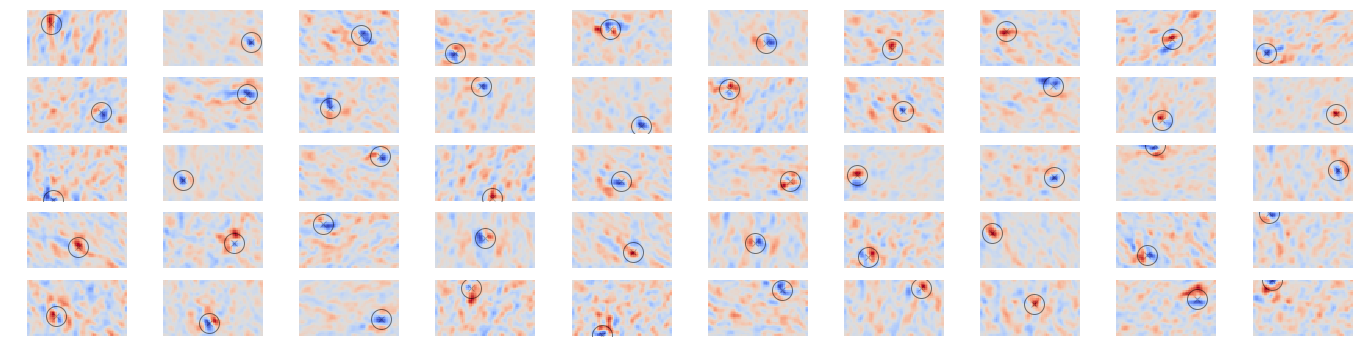

In [10]:
"""
Plot example RFs
"""
print('Plotting a few example RFs')
f, ax = plt.subplots(5,10,figsize=(24,6))
for k in range(50):
    plt.subplot(5,10,k+1)
    nidx = np.random.randint(NNeu)
    plt.imshow(ReceptiveFields[nidx,:,:],cmap = 'coolwarm',vmin = -1,vmax=1)    
    plt.plot(RxVec[nidx],RyVec[nidx],'o',markersize=20,mec='k',mfc="None",alpha = 0.5)
    plt.plot(RxVec[nidx],RyVec[nidx],'kx',alpha=0.25)
    plt.axis('off')
plt.show()
#f.savefig("./Figures/Receptive-Fields.pdf", bbox_inches='tight')

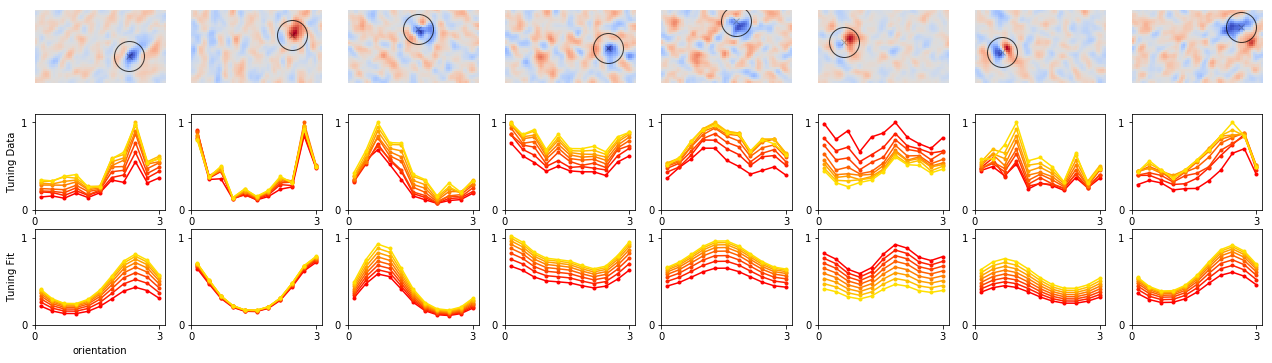

In [11]:
"""
Plot RF, tuning data and fit to tuning data for some example neurons
"""

Nplots = 8
fig, ax = plt.subplots(3,Nplots,figsize=(22,6))
for k in range(Nplots):
    nidx = np.random.randint(NNeu)
    ax[0,k].imshow(ReceptiveFields[nidx,:,:],cmap = 'coolwarm',vmin = -1,vmax=1)    
    ax[0,k].plot(RxVec[nidx],RyVec[nidx],'o',markersize=30,mec='k',mfc="None",alpha = 0.75)
    ax[0,k].plot(RxVec[nidx],RyVec[nidx],'kx',alpha=0.25)
    ax[0,k].axis('off')
    
    for n in range(Nbins_c):
        ax[1,k].plot(ori_set,TuningCurves_2D[nidx,n]/TuningCurves_Max[nidx],color=tuple([1,n*0.125,0]),marker ='.')
        ax[2,k].plot(ori_set,TuningCurves_Fit[nidx,n],color=tuple([1,n*0.125,0]),marker ='.')
    ax[1,k].set_xticks([0,3])
    ax[2,k].set_xticks([0,3])
    ax[1,k].set_yticks([0,1])
    ax[2,k].set_yticks([0,1])
    ax[1,k].axis([0,np.pi,0,1.1])
    ax[2,k].axis([0,np.pi,0,1.1])

ax[1,0].set_ylabel('Tuning Data')
ax[2,0].set_ylabel('Tuning Fit')
ax[2,0].set_xlabel('orientation')
plt.show()

#fig.savefig("./Figures/Tuning-Curves.pdf", bbox_inches='tight')

Distribution of parameters of Von Mises tuning function


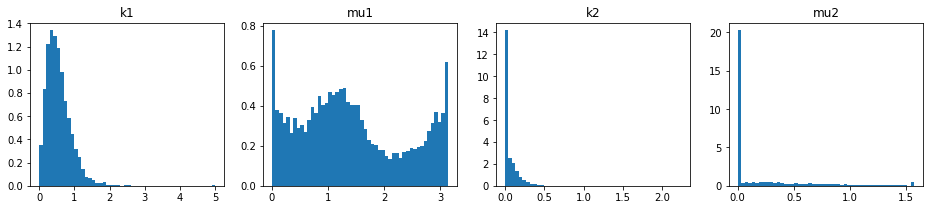

In [13]:
"""
Plot histograms of the von Mises parameters
"""
print('Distribution of parameters of Von Mises tuning function')
fig, ax = plt.subplots(1,4,figsize=(16,3))

ax[0].hist(k1,50,density=1)
ax[0].set_title('k1')
ax[1].hist(mu1,50,density=1)
ax[1].set_title('mu1')
ax[2].hist(k2,50,density=1)
ax[2].set_title('k2')
ax[3].hist(mu2,50,density=1)
ax[3].set_title('mu2')
plt.show()
fig.savefig("./Figures/Tuning-parameters.pdf", bbox_inches='tight')

In [14]:
"""
Max contrast value in the Monet clips. 
We used this to normalize the contrast bins used to compute the tuning curves.
"""

MMax = np.array([93.85158576916126]) #This is the value of MMax that was computed

In [15]:
"""
Load the local orientations and contrasts for Varma 30fps movies if they have not been computed already
"""


fname = './Varma_30fps/EstimatedContrast_VarmaExtendedFull.mat'
if Path(fname).exists():
    Data = loadmat(fname)
    ChatFull = Data['ChatFull']
    VMax = Data['VMax'].squeeze()
    fname = './Varma_30fps/EstimatedOrientation_VarmaExtendedFull.mat'
    Data = loadmat(fname)
    OhatFull = Data['OhatFull']
    del Data
    
else:
    VarmaMovies = np.load('./Varma_30fps/VarmaExtendedFull.npy')
    T, NClipsVarma = VarmaMovies.shape[2:]
    OhatFull = np.zeros(VarmaMovies.shape)
    ChatFull = np.zeros(VarmaMovies.shape)

    # paramters for estimating orientation and contrast
    ksize = 19
    sigma_o = 5
    sigma_c = 5
    rs = 1.0

    for clip in tqdm(range(NClipsVarma)):
            for t in range(T):
                OhatFull[:,:,t,clip], ChatFull[:,:,t,clip] = Extract_Orientation_Contrast(np.double(VarmaMovies[:,:,t,clip]),ksize, sigma_o, sigma_c, rs)
                
    # Quantize Chat and Ohat
    VMax = ChatFull.max()
    print(VMax)
    OhatFull = np.uint8(np.floor(256*OhatFull/np.pi))
    ChatFull = np.uint8(np.floor(256*ChatFull/VMax))

    # save the files
    mdict = {'OhatFull':OhatFull}
    fname = './Varma_30fps/EstimatedOrientation_VarmaExtendedFull.mat'
    savemat(fname, mdict)

    mdict = {'ChatFull':ChatFull, 'VMax':VMax}
    fname = './Varma_30fps/EstimatedContrast_VarmaExtendedFull.mat'
    savemat(fname, mdict)   
    


In [16]:
"""
Take time steps 3 to 603. Remember we used only 603 time steps to generate the responses.
And Eric's model discards responses to first 3 time steps
"""
OhatFull = OhatFull[:,:,3:603]
ChatFull = ChatFull[:,:,3:603]

100%|██████████| 6590/6590 [00:28<00:00, 232.23it/s]


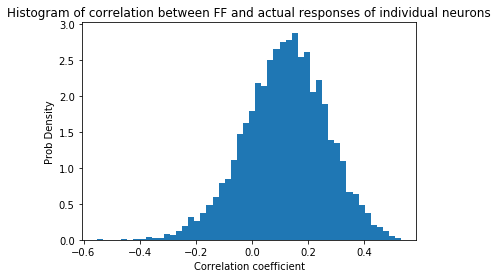

In [22]:
"""
Load the Varma responses and compute the feedforward responses
"""
r_name = './EricNet_Tiled/VarmaResponses/VarmaExtended_full_responses_' + str(dataset) + '.npy'
VarmaResponses = np.load(r_name)
VarmaResponses = VarmaResponses[:,:,NIdx] #choose only neurons with good RFs
FFResponses = np.zeros(VarmaResponses.shape,dtype='float32')

OhatFull = OhatFull.transpose([3,2,0,1])
ChatFull = ChatFull.transpose([3,2,0,1])

for nn in tqdm(range(NNeu)):
    px = RxVec[nn]
    py = RyVec[nn]
    C_input = np.expand_dims(ChatFull[:,:,py,px]/256,axis=0)*VMax/MMax
    O_input = np.expand_dims(OhatFull[:,:,py,px]*np.pi/256,axis=0)
    tuningFn_inputs = np.concatenate((C_input, O_input),axis=0)
    FFResponses[:,:,nn] = np.float32(TuningFunction(tuningFn_inputs,c_A[nn],c_B[nn],c_C[nn],k1[nn],mu1[nn],k2[nn],mu2[nn])*TuningCurves_Max[nn])
    
# compute correlation between the responses
CorrVec = np.zeros([NNeu])
for nn in tqdm(range(NNeu)):
    CorrVec[nn] = np.corrcoef(FFResponses[:,:,nn].flatten(),VarmaResponses[:,:,nn].flatten())[0,1]
    
plt.hist(CorrVec,50,density=1)
plt.xlabel('Correlation coefficient')
plt.ylabel('Prob Density')
plt.title('Histogram of correlation between FF and actual responses of individual neurons')
plt.show()

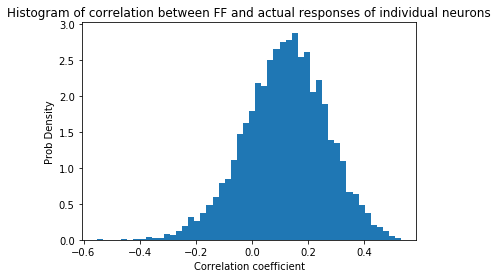

In [24]:
fig = plt.figure()
plt.hist(CorrVec,50,density=1)
plt.xlabel('Correlation coefficient')
plt.ylabel('Prob Density')
plt.title('Histogram of correlation between FF and actual responses of individual neurons')
plt.show()
fig.savefig("./Figures/ResponseCorr.pdf", bbox_inches='tight')

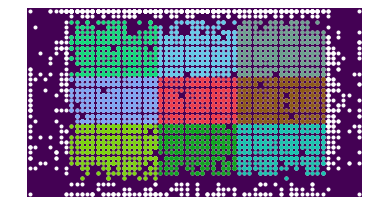

[574. 749. 613. 593. 576. 541. 766. 692. 617.]


In [21]:
"""
Construct the PPCs based on RF centers of the neurons
"""

# X_C = np.int(np.round(RxVec.mean()))
# Y_C = np.int(np.round(RyVec.mean()))

X_C = 32
Y_C = 17

id_PPC = []

# Pick a Mx x My grid of groups(Mx and My should be odd)
# Each individual group is itself a MxM grid of pixels
M = 9

Mx = 3
My = 3
Mxb2 = np.int((Mx-1)/2)
Myb2 = np.int((My-1)/2)

# A are size along each axis
Ay = 9
Ax = 15
Axb2 = np.int((Ax-1)/2)
Ayb2 = np.int((Ay-1)/2)

x0 = X_C - Axb2 -Ax*Mxb2
y0 = Y_C - Ayb2 -Ay*Myb2

PopulationCenters = np.zeros([Mx*My,2])

N_populations = 0

for ix in range(Mx):
    if ix == 0:
        id_x = pick_indices(RxVec,x0 + ix*Ax-2, x0 + (ix+1)*Ax - 1)
    elif ix == Mx-1:
        id_x = pick_indices(RxVec,x0 + ix*Ax, x0 + (ix+1)*Ax + 1)
    else:
        id_x = pick_indices(RxVec,x0 + ix*Ax, x0 + (ix+1)*Ax - 1)       
    for iy in range(My):
        if iy == 0:
            id_y = pick_indices(RyVec,y0 + iy*Ay-2, y0 + (iy+1)*Ay - 1)
        elif iy == My -1:
            id_y = pick_indices(RyVec,y0 + iy*Ay, y0 + (iy+1)*Ay + 1)
        else:
            id_y = pick_indices(RyVec,y0 + iy*Ay, y0 + (iy+1)*Ay - 1)
        id_PPC.append(np.intersect1d(id_x,id_y))
        PopulationCenters[N_populations,0] = x0 + ix*Ax + Axb2
        PopulationCenters[N_populations,1] = y0 + iy*Ay + Ayb2
        N_populations = N_populations + 1
        
# plot the RF centers and show grouping of the PPCs
fig = plt.figure()
plt.imshow(np.zeros([Ny,Nx]))
plt.plot(np.round(RxVec),np.round(RyVec),'w.')
for i in range(N_populations):
    plt.plot(np.round(RxVec[id_PPC[i]]),np.round(RyVec[id_PPC[i]]),color=tuple(np.random.rand(3)),marker='.',linestyle='None')
    
plt.axis('off')
plt.show()
fig.savefig("./Figures/Populations.pdf", bbox_inches='tight')
# Find the no. of neurons in each population
NNeu_Pops = np.zeros([N_populations])
for i in range(len(id_PPC)):
    NNeu_Pops[i] = len(id_PPC[i])

print(NNeu_Pops)


In [18]:
"""
Create population responses
"""

NClipsVarma, T = VarmaResponses.shape[0:2]

FFResponses = FFResponses.transpose(0,2,1)
VarmaResponses = VarmaResponses.transpose(0,2,1)

# Compute the cos and sin statistics for feedforward and actual neural responses

FF_cos1 = np.zeros([NClipsVarma,N_populations,T])
FF_sin1 = np.zeros([NClipsVarma,N_populations,T])
FF_cos2 = np.zeros([NClipsVarma,N_populations,T])
FF_sin2 = np.zeros([NClipsVarma,N_populations,T])

R_cos1 = np.zeros([NClipsVarma,N_populations,T])
R_sin1 = np.zeros([NClipsVarma,N_populations,T])
R_cos2 = np.zeros([NClipsVarma,N_populations,T])
R_sin2 = np.zeros([NClipsVarma,N_populations,T])

AverageNeuronsinPPC = np.mean(NNeu_Pops)

# normalizeByNNeu = 1 #if we want to scale the number of neurons in each population to the average across populations
normalizeByNNeu = 0 # don't normalize, I will normalize after I combine the two populations

# Add extra dimensions to Mu and K vectors
k1_E = expandN_dims(k1,2).transpose([1,0,2])
k2_E = expandN_dims(k2,2).transpose([1,0,2])
mu1_E = expandN_dims(mu1,2).transpose([1,0,2])
mu2_E = expandN_dims(mu2,2).transpose([1,0,2])

for ii in range(len(id_PPC)):
    
    idx = id_PPC[ii]
    k1_PPC = k1_E[:,idx,:]
    k2_PPC = k2_E[:,idx,:]
    mu1_PPC = mu1_E[:,idx,:]
    mu2_PPC = mu2_E[:,idx,:]

    if normalizeByNNeu:
        Z = len(idx)/AverageNeuronsinPPC
    else:
        Z = 1
        
    FF_cos1[:,ii,:] = np.sum(FFResponses[:,idx,:]*k1_PPC*np.cos(2*mu1_PPC),axis=1)/Z
    FF_sin1[:,ii,:] = np.sum(FFResponses[:,idx,:]*k1_PPC*np.sin(2*mu1_PPC),axis=1)/Z
    FF_cos2[:,ii,:] = np.sum(FFResponses[:,idx,:]*k2_PPC*np.cos(4*mu2_PPC),axis=1)/Z
    FF_sin2[:,ii,:] = np.sum(FFResponses[:,idx,:]*k2_PPC*np.sin(4*mu2_PPC),axis=1)/Z
    
    R_cos1[:,ii,:] = np.sum(VarmaResponses[:,idx,:]*k1_PPC*np.cos(2*mu1_PPC),axis=1)/Z
    R_sin1[:,ii,:] = np.sum(VarmaResponses[:,idx,:]*k1_PPC*np.sin(2*mu1_PPC),axis=1)/Z
    R_cos2[:,ii,:] = np.sum(VarmaResponses[:,idx,:]*k2_PPC*np.cos(4*mu2_PPC),axis=1)/Z
    R_sin2[:,ii,:] = np.sum(VarmaResponses[:,idx,:]*k2_PPC*np.sin(4*mu2_PPC),axis=1)/Z
    

In [19]:
# """
# Compute the correlations between the population responses
# """
# PopCorrCoeff_c1 = np.zeros([N_populations])
# PopCorrCoeff_s1 = np.zeros([N_populations])
# PopCorrCoeff_c2 = np.zeros([N_populations])
# PopCorrCoeff_s2 = np.zeros([N_populations])

# for k in range(N_populations):
#     PopCorrCoeff_c1[k] = np.corrcoef(FF_cos1[:,k,:].flatten(),R_cos1[:,k,:].flatten())[0,1]
#     PopCorrCoeff_c2[k] = np.corrcoef(FF_cos2[:,k,:].flatten(),R_cos2[:,k,:].flatten())[0,1]
#     PopCorrCoeff_s1[k] = np.corrcoef(FF_sin1[:,k,:].flatten(),R_sin1[:,k,:].flatten())[0,1]
#     PopCorrCoeff_s2[k] = np.corrcoef(FF_sin2[:,k,:].flatten(),R_sin2[:,k,:].flatten())[0,1]

In [4]:
# plt.plot(PopCorrCoeff_c1,'.-')
# plt.plot(PopCorrCoeff_c2,'.-')
# plt.plot(PopCorrCoeff_s1,'.-')
# plt.plot(PopCorrCoeff_s2,'.-')
# plt.axis([0,8,0,1])
# plt.xlabel('Population index')
# plt.ylabel('Correlation coefficient')
# plt.title('Correlation between FF and actual response projections')
# plt.legend(['cos1', 'cos2', 'sin1', 'sin2'])
# plt.show()


In [24]:
"""
Save the population responses
"""
mdict = {'R_cos1': R_cos1, 'R_sin1': R_sin1, 'FF_cos1': FF_cos1, 'FF_sin1': FF_sin1, 'R_cos2': R_cos2, 'R_sin2': R_sin2, 'FF_cos2': FF_cos2, 'FF_sin2': FF_sin2, 'NNeu_Pops':NNeu_Pops}
fname = './EricNet_Tiled/UnNormalizedPopulationData_' + str(dataset) + '.mat'
savemat(fname, mdict)


## Combining population responses from both datasets

In [2]:
Data = loadmat('./EricNet_Tiled/UnNormalizedPopulationData_1.mat')
R_cos1_1 = Data['R_cos1']
R_sin1_1 = Data['R_sin1']
R_cos2_1 = Data['R_cos2']
R_sin2_1 = Data['R_sin2']
FF_cos1_1 = Data['FF_cos1']
FF_sin1_1 = Data['FF_sin1']
FF_cos2_1 = Data['FF_cos2']
FF_sin2_1 = Data['FF_sin2']
NNeuPops_1 = Data['NNeu_Pops'].squeeze()


Data = loadmat('./EricNet_Tiled/UnNormalizedPopulationData_9.mat')
R_cos1_9 = Data['R_cos1']
R_sin1_9 = Data['R_sin1']
R_cos2_9 = Data['R_cos2']
R_sin2_9 = Data['R_sin2']
FF_cos1_9 = Data['FF_cos1']
FF_sin1_9 = Data['FF_sin1']
FF_cos2_9 = Data['FF_cos2']
FF_sin2_9 = Data['FF_sin2']
NNeuPops_9 = Data['NNeu_Pops'].squeeze()

NNeuPops = NNeuPops_1 + NNeuPops_9
AverageNeuronsinPPC = np.mean(NNeuPops)
NNeuPops = expandN_dims(NNeuPops,2).transpose(1,0,2)

R_cos1 = (R_cos1_1 + R_cos1_9)*AverageNeuronsinPPC/NNeuPops
R_cos2 = (R_cos2_1 + R_cos2_9)*AverageNeuronsinPPC/NNeuPops
R_sin1 = (R_sin1_1 + R_sin1_9)*AverageNeuronsinPPC/NNeuPops
R_sin2 = (R_sin2_1 + R_sin2_9)*AverageNeuronsinPPC/NNeuPops

FF_cos1 = (FF_cos1_1 + FF_cos1_9)*AverageNeuronsinPPC/NNeuPops
FF_cos2 = (FF_cos2_1 + FF_cos2_9)*AverageNeuronsinPPC/NNeuPops
FF_sin1 = (FF_sin1_1 + FF_sin1_9)*AverageNeuronsinPPC/NNeuPops
FF_sin2 = (FF_sin2_1 + FF_sin2_9)*AverageNeuronsinPPC/NNeuPops

In [3]:
"""
Compute the correlations between the population responses
"""
NNeuPops = NNeuPops.squeeze()
N_populations = len(NNeuPops)
PopCorrCoeff_c1 = np.zeros([N_populations])
PopCorrCoeff_s1 = np.zeros([N_populations])
PopCorrCoeff_c2 = np.zeros([N_populations])
PopCorrCoeff_s2 = np.zeros([N_populations])

for k in range(N_populations):
    PopCorrCoeff_c1[k] = np.corrcoef(FF_cos1[:,k,:].flatten(),R_cos1[:,k,:].flatten())[0,1]
    PopCorrCoeff_c2[k] = np.corrcoef(FF_cos2[:,k,:].flatten(),R_cos2[:,k,:].flatten())[0,1]
    PopCorrCoeff_s1[k] = np.corrcoef(FF_sin1[:,k,:].flatten(),R_sin1[:,k,:].flatten())[0,1]
    PopCorrCoeff_s2[k] = np.corrcoef(FF_sin2[:,k,:].flatten(),R_sin2[:,k,:].flatten())[0,1]

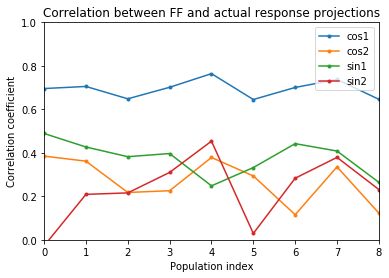

In [4]:
plt.plot(PopCorrCoeff_c1,'.-')
plt.plot(PopCorrCoeff_c2,'.-')
plt.plot(PopCorrCoeff_s1,'.-')
plt.plot(PopCorrCoeff_s2,'.-')
plt.axis([0,8,0,1])
plt.xlabel('Population index')
plt.ylabel('Correlation coefficient')
plt.title('Correlation between FF and actual response projections')
plt.legend(['cos1', 'cos2', 'sin1', 'sin2'])
plt.show()


In [11]:
"""
Compute the correlations between the population responses for the long correlation scales in stimulus
"""
T = R_cos1.shape[2]
R_cos1_L = np.zeros([80,N_populations,T])
R_cos2_L = np.zeros([80,N_populations,T])
R_sin1_L = np.zeros([80,N_populations,T])
R_sin2_L = np.zeros([80,N_populations,T])

FF_cos1_L = np.zeros([80,N_populations,T])
FF_cos2_L = np.zeros([80,N_populations,T])
FF_sin1_L = np.zeros([80,N_populations,T])
FF_sin2_L = np.zeros([80,N_populations,T])

R_cos1_L[0:40] = R_cos1[40:80]
R_cos2_L[0:40] = R_cos2[40:80]
R_sin1_L[0:40] = R_sin1[40:80]
R_sin2_L[0:40] = R_sin2[40:80]

FF_cos1_L[0:40] = FF_cos1[40:80]
FF_cos2_L[0:40] = FF_cos2[40:80]
FF_sin1_L[0:40] = FF_sin1[40:80]
FF_sin2_L[0:40] = FF_sin2[40:80]

R_cos1_L[40:80] = R_cos1[120:160]
R_cos2_L[40:80] = R_cos2[120:160]
R_sin1_L[40:80] = R_sin1[120:160]
R_sin2_L[40:80] = R_sin2[120:160]

FF_cos1_L[40:80] = FF_cos1[120:160]
FF_cos2_L[40:80] = FF_cos2[120:160]
FF_sin1_L[40:80] = FF_sin1[120:160]
FF_sin2_L[40:80] = FF_sin2[120:160]



PopCorrCoeff_c1 = np.zeros([N_populations])
PopCorrCoeff_s1 = np.zeros([N_populations])
PopCorrCoeff_c2 = np.zeros([N_populations])
PopCorrCoeff_s2 = np.zeros([N_populations])

for k in range(N_populations):
    PopCorrCoeff_c1[k] = np.corrcoef(FF_cos1_L[:,k,:].flatten(),R_cos1_L[:,k,:].flatten())[0,1]
    PopCorrCoeff_c2[k] = np.corrcoef(FF_cos2_L[:,k,:].flatten(),R_cos2_L[:,k,:].flatten())[0,1]
    PopCorrCoeff_s1[k] = np.corrcoef(FF_sin1_L[:,k,:].flatten(),R_sin1_L[:,k,:].flatten())[0,1]
    PopCorrCoeff_s2[k] = np.corrcoef(FF_sin2_L[:,k,:].flatten(),R_sin2_L[:,k,:].flatten())[0,1]

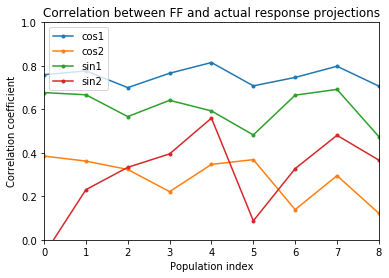

In [12]:
plt.plot(PopCorrCoeff_c1,'.-')
plt.plot(PopCorrCoeff_c2,'.-')
plt.plot(PopCorrCoeff_s1,'.-')
plt.plot(PopCorrCoeff_s2,'.-')
plt.axis([0,8,0,1])
plt.xlabel('Population index')
plt.ylabel('Correlation coefficient')
plt.title('Correlation between FF and actual response projections')
plt.legend(['cos1', 'cos2', 'sin1', 'sin2'])
plt.show()


In [13]:
"""
Compute the correlations between the population responses for the short correlation scales in stimulus
"""
T = R_cos1.shape[2]
R_cos1_S = np.zeros([80,N_populations,T])
R_cos2_S = np.zeros([80,N_populations,T])
R_sin1_S = np.zeros([80,N_populations,T])
R_sin2_S = np.zeros([80,N_populations,T])

FF_cos1_S = np.zeros([80,N_populations,T])
FF_cos2_S = np.zeros([80,N_populations,T])
FF_sin1_S = np.zeros([80,N_populations,T])
FF_sin2_S = np.zeros([80,N_populations,T])

R_cos1_S[0:40] = R_cos1[0:40]
R_cos2_S[0:40] = R_cos2[0:40]
R_sin1_S[0:40] = R_sin1[0:40]
R_sin2_S[0:40] = R_sin2[0:40]

FF_cos1_S[0:40] = FF_cos1[0:40]
FF_cos2_S[0:40] = FF_cos2[0:40]
FF_sin1_S[0:40] = FF_sin1[0:40]
FF_sin2_S[0:40] = FF_sin2[0:40]

R_cos1_S[40:80] = R_cos1[80:120]
R_cos2_S[40:80] = R_cos2[80:120]
R_sin1_S[40:80] = R_sin1[80:120]
R_sin2_S[40:80] = R_sin2[80:120]

FF_cos1_S[40:80] = FF_cos1[80:120]
FF_cos2_S[40:80] = FF_cos2[80:120]
FF_sin1_S[40:80] = FF_sin1[80:120]
FF_sin2_S[40:80] = FF_sin2[80:120]



PopCorrCoeff_c1 = np.zeros([N_populations])
PopCorrCoeff_s1 = np.zeros([N_populations])
PopCorrCoeff_c2 = np.zeros([N_populations])
PopCorrCoeff_s2 = np.zeros([N_populations])

for k in range(N_populations):
    PopCorrCoeff_c1[k] = np.corrcoef(FF_cos1_S[:,k,:].flatten(),R_cos1_S[:,k,:].flatten())[0,1]
    PopCorrCoeff_c2[k] = np.corrcoef(FF_cos2_S[:,k,:].flatten(),R_cos2_S[:,k,:].flatten())[0,1]
    PopCorrCoeff_s1[k] = np.corrcoef(FF_sin1_S[:,k,:].flatten(),R_sin1_S[:,k,:].flatten())[0,1]
    PopCorrCoeff_s2[k] = np.corrcoef(FF_sin2_S[:,k,:].flatten(),R_sin2_S[:,k,:].flatten())[0,1]

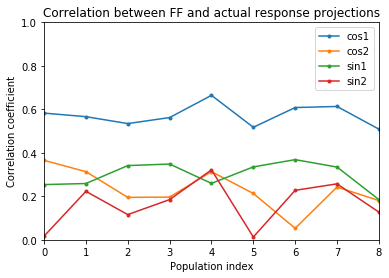

In [14]:
plt.plot(PopCorrCoeff_c1,'.-')
plt.plot(PopCorrCoeff_c2,'.-')
plt.plot(PopCorrCoeff_s1,'.-')
plt.plot(PopCorrCoeff_s2,'.-')
plt.axis([0,8,0,1])
plt.xlabel('Population index')
plt.ylabel('Correlation coefficient')
plt.title('Correlation between FF and actual response projections')
plt.legend(['cos1', 'cos2', 'sin1', 'sin2'])
plt.show()


In [18]:
np.corrcoef(FF_sin1_L.flatten(),R_sin1_L.flatten())

array([[1.        , 0.67324491],
       [0.67324491, 1.        ]])

In [8]:
"""
Save the population responses
"""
mdict = {'R_cos1': R_cos1, 'R_sin1': R_sin1, 'FF_cos1': FF_cos1, 'FF_sin1': FF_sin1, 'R_cos2': R_cos2, 'R_sin2': R_sin2, 'FF_cos2': FF_cos2, 'FF_sin2': FF_sin2}
fname = './EricNet_Tiled/PopulationStatisticsData_EricNet.mat'
savemat(fname, mdict)


## Processing CIFAR data

In [2]:
"""
Combining the Varma responses into one file
"""
# V1 = np.load('./EricNet_Tiled/VarmaResponses/VarmaExtended_1_responses_9.npy')
# V1.shape
# Vfull = np.zeros([160,600,11402],dtype='float32')
# Vfull[0:80] = V1
# del V1
# V2 = np.load('./EricNet_Tiled/VarmaResponses/VarmaExtended_2_responses_9.npy')
# Vfull[80:] = V2
# del V2
# np.save('./EricNet_Tiled/VarmaResponses/VarmaExtended_full_responses_9.npy',Vfull)